In [1]:
# Plot related imports

import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
import matplotlib.dates as matdates
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns

sns.set_style("ticks")
fontpath = expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [2]:
# Other imports
import os
import sys
sys.path.insert(0, os.path.abspath('/data/savvas/incels/manosphere_analysis/helpers/'))
from plot import set_size
from helpers import jaccard, populate_bin_with_channel, add_user_to_bin, bins_y_o, bins_t_o, bin_to_df
from helpers import colors, _jaccard, bins_y_s, bins_t_s

from matplotlib.patches import Rectangle
import matplotlib.cm as cm
from sqlitedict import SqliteDict
import itertools
import numpy as np
import pandas as pd

In [3]:
# Helper functions

def get_color_overlap(x):
    if x < 0.1:
        return "#FFFFFF"
    if x < 0.2:
        return "#DCDCDC"
    if x < 0.3:
        return "#A9A9A9"
    if x < 0.5:
        return "#696969"
    if x < 0.75:
        return "#2F4F4F"
    return "#222222"

def populate_bin_with_channel(channel, channel_dict, bin_dict):
    if channel in channel_dict:
        for user in channel_dict[channel]:
            add_user_to_bin(bin_dict, user["author"], user["timestamp"]*1000)

def bin_to_df(keys, bin1, bin2, fun, interval=False):
    print(interval)
    vals = []
    for k in keys:
        val = fun(bin1[k], bin2[k], interval)
        val["idx"] = k
        vals.append(val)
    return pd.DataFrame(vals)

def _jaccard(s1, s2):
    intersection_cardinality = len(set.intersection(*[s1, s2]))
    union_cardinality = len(s1) + len(s2) - intersection_cardinality
    return intersection_cardinality / float(union_cardinality)

def jaccard(x, y, interval, random_sample_size=100):
    s_x, s_y = set([it_x for it_x in x]), set([it_y for it_y in y])
    
    sample_size = min(len(s_x), len(s_y))
    
    if len(s_x) > len(s_y):
        to_sample = np.array(list(set(s_x)))
        other = s_y
    else:
        to_sample = np.array(list(set(s_y)))
        other = s_x

    tmp = {
        "x": len(s_x),
        "x-y": len(s_x - s_y),
        "y-x": len(s_y - s_x),
        "y": len(s_y),
        "intersection": len(s_x.intersection(s_y)),
        "jaccard": 0
    }
    
    if interval:        
        jaccards = []

        for i in range(random_sample_size):
            tmp_sample = np.random.choice(to_sample, size=sample_size, replace=False)
            tmp_sample = set(tmp_sample)

            n_x, n_y = len(tmp_sample), len(other)
            if n_x == 0 or n_y == 0:
                jaccards.append(0.0)
            else:
                jaccards.append(_jaccard(tmp_sample, other))

        sorted(jaccards)
        jaccards = np.array(jaccards)
        p = 0.95
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        n = len(jaccards)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        tmp["lower_jac"] = jaccards[l_indx]
        tmp["upper_jac"] = jaccards[u_indx]        

    n_x, n_y = len(s_x), len(s_y)

    if n_x == 0 or n_y == 0:
        tmp["jaccard"] = 0
        return tmp
        
    tmp["jaccard"] = _jaccard(s_x, s_y)
    return tmp

In [4]:
# Helper variables

channel_dict = SqliteDict("/data/savvas/incels/data/channels_dict.sqlite", tablename="channels")
df_labels = pd.read_csv("../helpers/labels.csv")
cats = ["pua", "incels", "trp", "health", "mgtow", "mra", "random"]

In [5]:
# Loads variables (1)

bins = {cat:{b:set() for b in bins_y_o} for cat in cats}

for cat, bin_dict in bins.items():
    if cat == "random":
        populate_bin_with_channel("random", channel_dict, bin_dict)
    else:
        for channel in df_labels.loc[df_labels["category"] == cat, "subreddits"]:
            populate_bin_with_channel(channel, channel_dict, bin_dict)

In [6]:
# Calculates shifted version

bins_shift = {cat:{b:set() for b in bins_y_o} for cat in cats}

for cat in cats:
    bin_dict = bins[cat]
    bin_sl_dict = bins_shift[cat]
    for idx in range(len(bins_y_o) - 1):
        shifted = sorted(bin_dict.keys())[idx+1]
        actual = sorted(bin_dict.keys())[idx]
        bin_sl_dict[shifted] = bin_dict[actual]

In [7]:
# Makes combinations

combs = list(itertools.combinations(cats,2))
bins_combs = {comb : bin_to_df(bins_y_o, bins[comb[0]], bins[comb[1]], 
                               jaccard, comb[0] == "random" or comb[1] == "random") for comb in combs}
bins_sl = {cat : bin_to_df(bins_y_o, bins[cat], bins_shift[cat], 
                           jaccard, cat == "random") for cat in cats}

False
False
False
False
False
True
False
False
False
False
True
False
False
False
True
False
False
True
False
True
True
False
False
False
False
False
False
True


In [8]:
df_list = []
for t, df in bins_combs.items():
    df["kind"] = "-".join(sorted(t))
    df["idx_str"] = [v[-2:] for v in bins_t_o]
    df["overlapx"] = df["intersection"] / df["x"]
    df["overlapx"] = df["overlapx"].fillna(0)
    df["coloroverlapx"] = df["overlapx"].apply(get_color_overlap)
    df["overlapy"] = df["intersection"] / df["y"]
    df["overlapy"] = df["overlapy"].fillna(0)
    df["coloroverlapy"] = df["overlapy"].apply(get_color_overlap)
    df_list.append(df)

for t, df in bins_sl.items():
    df["kind"] = t + "-" + t
    df["xpct"] = df["x"] / df.sum().x
    df["idx_str"] = [v[-2:] for v in bins_t_o]
    df["overlapx"] = df["intersection"] / df["x"]
    df["overlapx"] = df["overlapx"].fillna(0)
    df["coloroverlapx"] = df["overlapx"].apply(get_color_overlap)
    df["overlapy"] = df["intersection"] / df["y"]
    df["overlapy"] = df["overlapy"].fillna(0)
    df["coloroverlapy"] = df["overlapy"].apply(get_color_overlap)
    
    df_list.append(df)
df_all = pd.concat(df_list)

/home/manoel/miniconda3/envs/manosphere/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



['pua', 'pua']
['pua', 'random']
['incels', 'pua']
['pua', 'random']
['pua', 'trp']
['pua', 'random']
['mgtow', 'pua']
['pua', 'random']
['mra', 'pua']
['pua', 'random']
['incels', 'incels']
['incels', 'random']
['incels', 'trp']
['incels', 'random']
['incels', 'mgtow']
['incels', 'random']
['incels', 'mra']
['incels', 'random']
['trp', 'trp']
['random', 'trp']
['mgtow', 'trp']
['random', 'trp']
['mra', 'trp']
['random', 'trp']
['mgtow', 'mgtow']
['mgtow', 'random']
['mgtow', 'mra']
['mgtow', 'random']
['mra', 'mra']
['mra', 'random']


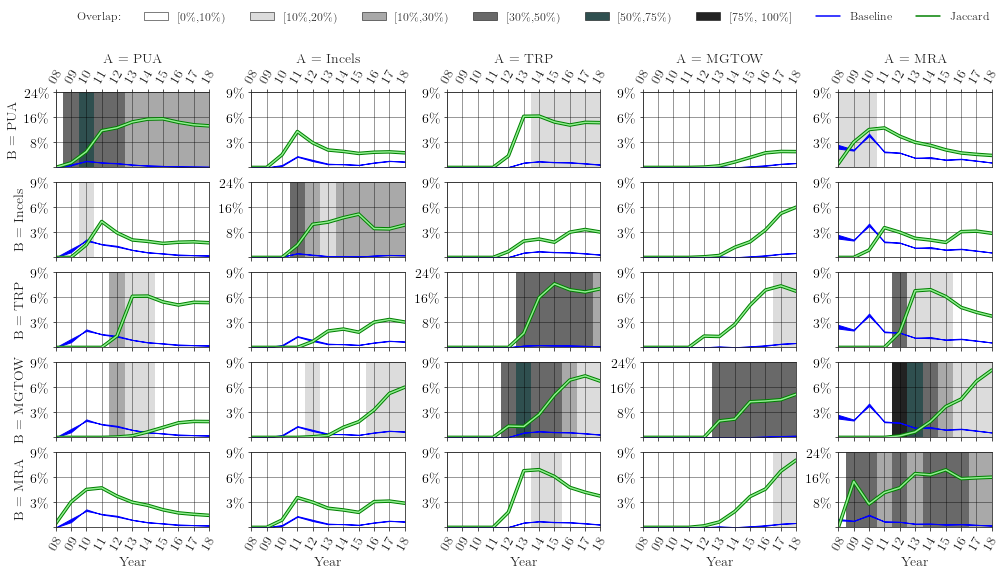

In [11]:
# Plots figures

fig, axs = plt.subplots(5, 5, figsize=(14, 8))
fig.subplots_adjust(wspace=0.275, top=0.85)

order = {0:"pua", 1:"incels", 2:"trp", 3:"mgtow", 4:"mra"}
correct_names = {"pua":"PUA", "incels":"Incels", "trp":"TRP", 
                 "mgtow":"MGTOW", "mra":"MRA", "random":"random"}

for idx, idy in itertools.combinations_with_replacement(list(range(5)), 2):
    normx = axs[idy][idx]
    flipx = axs[idx][idy]
    
    print(sorted([order[idx], order[idy]]))
    print(sorted([order[idx], "random"]))
    df_tmp = df_all.loc[df_all.kind == "-".join(sorted([order[idx], order[idy]]))]
    
    df_tmp2 = df_all.loc[df_all.kind == "-".join(sorted([order[idx], "random"]))]
    l = sns.lineplot(x="idx_str",  y="jaccard", data=df_tmp, ax=normx, color="green", lw=3.5)
    l = sns.lineplot(x="idx_str",  y="jaccard", data=df_tmp, ax=normx, color="lightgreen")
    normx.fill_between(df_tmp2["idx_str"], df_tmp2["lower_jac"], df_tmp2["upper_jac"], alpha=1, color="blue")

    if idx != idy:
        df_tmp2 = df_all.loc[df_all.kind == "-".join(sorted([order[idy], "random"]))]

        sns.lineplot(x="idx_str",  y="jaccard", data=df_tmp, ax=flipx, color="green", lw=3.5)   
        sns.lineplot(x="idx_str",  y="jaccard", data=df_tmp, ax=flipx, color="lightgreen")        
        flipx.fill_between(df_tmp2["idx_str"], df_tmp2["lower_jac"], df_tmp2["upper_jac"], alpha=1, color="blue")
        
    count = 0
    for _, row in df_tmp.iterrows():
        row = dict(row)
        if row["idx"][0] < 1209556800000:
            continue

        r1 = patches.Rectangle((count-0.5, 0), 1, 9, color=row["coloroverlapx"],  zorder=0)
        r2 = patches.Rectangle((count-0.5, 0), 1, 9, color=row["coloroverlapy"],  zorder=0)
        flipx.add_patch(r1)            
        normx.add_patch(r2) 
        count += 1
            
    for ax, flip in zip([normx, flipx], [False, True]):
    
        if idx == idy and flip:
            continue
        
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xlim([0,10])
        ax.xaxis.grid(color="#000000", linestyle='solid', alpha=0.5)
        ax.yaxis.grid(color="#000000", linestyle='solid', alpha=0.5)
        ax.set_yticklabels(["", "3\%", "6\%", "9\%"], color="black")
        ax.set_ylim([0,0.09])
        ax.set_yticks([0, 0.03, 0.06, 0.09])
        
        if idx == 0 and flip or (idx == 0 and idy == 0):
            ax.xaxis.tick_top()

        elif idy != 4 or flip: 
            ax.set_xticklabels([])
            
        if idy == 4 and not flip:
            ax.set_xlabel("Year")


        if idx == 0 and (flip or idx==idy):
            ax.xaxis.set_label_position("top")
            ax.set_xlabel("A = " + correct_names[order[idy]])

        if idx == 0 and not flip:
            ax.set_yticks([0, 0.03, 0.06, 0.09])
            ax.set_yticklabels(["", "3\%", "6\%", "9\%"], color="black")
            ax.set_ylabel("B = " + correct_names[order[idy]])

        if idx == idy:
            ax.yaxis.set_label_position("left")

            ax.set_ylim([0,0.24])
            ax.set_yticks([0, 0.08, 0.16, 0.24])
            ax.set_yticklabels(["", "8\%", "16\%", "24\%"], color="black")
            
        for tick in ax.get_xticklabels():
            tick.set_rotation(60)
            
custom_lines = [
patches.Rectangle((0,0),0.1,0.1,facecolor='#FFFFFF'),
patches.Rectangle((0,0),1,1,facecolor='#FFFFFF', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#DCDCDC', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#A9A9A9', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#696969', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#2F4F4F', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#222222', edgecolor="#000000", lw=0.5),
        Line2D([0], [0], color="blue", lw=1.5, ls="-"),
    Line2D([0], [0], color="green", lw=1.5, ls="-")
]

axs[0][2].legend(custom_lines, ['Overlap:', '[0\%,10\\%)', '[10\%,20\\%)', '[10\%,30\%)', 
                                '[30\%,50\%)', '[50\%,75\%)', '[75\%, 100\%]', "Baseline", "Jaccard"], 
          loc="center", ncol=9, bbox_to_anchor=(0.45, 2), frameon=False, fontsize=12)

set_size(fig, (14,8))
fig.savefig("/data/savvas/incels/manosphere_analysis/images/user_inter_reddit.pdf", bbox_inches='tight')


---